In [251]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
#import tensorflow as tf             # for bulk image resize
import os
import glob
import random
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage import data, exposure
from PIL import Image
from tqdm import tqdm_notebook as tqdm

from sklearn.ensemble import RandomForestClassifier

#from tensorflow.keras import layers
#from tensorflow import keras
#from tensorflow.keras import backend as K

In [275]:
def load_images(directory_path, target_size):
    images = []
    labels = []
    filenames = []

    # Iterate over the files in the directory
    for filename in os.listdir(directory_path):
        # Check if the file is an image (you can modify the condition based on your requirements)
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Construct the full file path
            file_path = os.path.join(directory_path, filename)

            try:
                # Load the image using PIL
                image = Image.open(file_path)

                # Resize the image to the target size
                resized_image = image.resize(target_size)

                # Convert the image to a NumPy array
                image_array = np.array(resized_image)

                # Append the image array to the list of images
                images.append(image_array)

                # Split the file name into label and rest of the name
                label, _ = filename.split("_", 1)  # Split only once

                # Append the label to the list of labels
                labels.append(label)

                # Append the filename to the list of filenames
                filenames.append(filename)
            except ValueError:
                print("Error processing file:", filename)

    # Convert the images, labels, and filenames lists to NumPy arrays
    images = np.stack(images)
    labels = np.array(labels)
    filenames = np.array(filenames)

    return images, labels, filenames

def flatten(data):
    data_resized = data / 255
    nsamples, nx, ny, nrgb = data_resized.shape
    return data.reshape((nsamples, nx * ny * nrgb)) 

def convert_to_hog(data, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_data = []
    for im in range(data.shape[0]):
        hog_data.append(hog(data[im, :, :, :], orientations=orientations, pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block, visualize=False, channel_axis=2, feature_vector=True))
    return np.array(hog_data)

def train_randomforest(train_X, train_Y, val_X, val_Y):
    num_est = [100, 200, 400, 800]
    max_depth = [1, 2, 4, 8, 16]
    class_weights = [None, 'balanced', 'balanced_subsample']

    best_acc = 0
    best_model = None
    best_est = None
    best_depth = None
    best_weight = None

    for e in tqdm(num_est):
        for d in max_depth:
            for w in class_weights:
                
                rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state = 25, class_weight = w).fit(train_X, train_Y)

                acc = f1_score(val_Y, rf.predict(val_X), average='macro')
                if (acc > best_acc):
                    best_acc = acc
                    best_model = rf
                    best_est = e
                    best_depth = d
                    best_weight = w
    
    return best_model, best_est, best_depth, best_weight

def plot_images(images, labels, filenames):
    # Plot the first ten images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(filenames[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show() 

def plot_hogimages(train_X, image_num=0):
    fd, hog_image = hog(train_X[image_num,:,:,:], orientations=16, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    # display image and HOG representation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(train_X[image_num,:,:,:], cmap=plt.cm.gray)
    ax1.set_title('Input image')
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

def plot_cm(model, test_X, test_Y):
    pred = model.predict(test_X)

    print(classification_report(test_Y, pred))

    conf_matrix = confusion_matrix(y_true=test_Y, y_pred=pred)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha = 0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize = 18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    print(classification_report(Y_test, pred))

(159, 244, 244, 3)
(120, 244, 244, 3)
(120, 244, 244, 3)


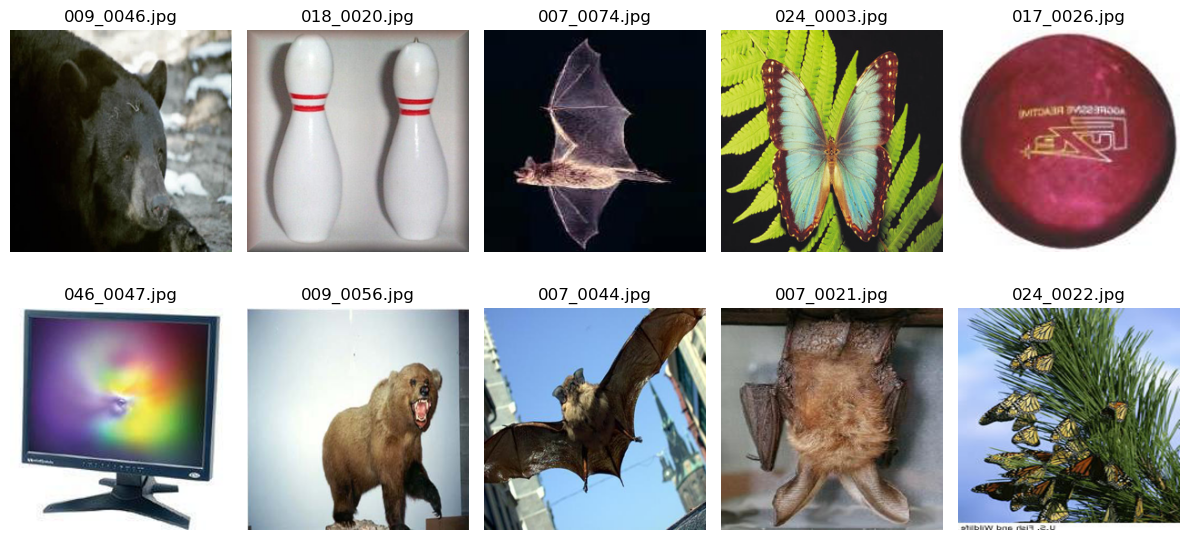

In [296]:
imagesize = 244
randomstate = 259

datasets_X, datasets_Y, datasets_label = load_images("DataPoints/Training/", target_size=(imagesize, imagesize))

train_X, others_X, train_Y, others_Y = train_test_split(datasets_X, datasets_Y, train_size=0.4, random_state=randomstate)
val_X, test_X, val_Y, test_Y = train_test_split(others_X, others_Y, train_size=0.5, random_state=randomstate)

train_label, others_label = train_test_split(datasets_label, train_size=0.4, random_state=randomstate)
val_label, test_label = train_test_split(datasets_label, train_size=0.5, random_state=randomstate)

print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

plot_images(train_X, train_Y, train_label)

In [285]:
train_X_flat = flatten(train_X)
test_X_flat = flatten(test_X)
val_X_flat = flatten(val_X)

print(train_X_flat.shape)
print(test_X_flat.shape)
print(val_X_flat.shape)

(159, 178608)
(120, 178608)
(120, 178608)


In [279]:
# num_est = [100, 200, 400, 800]
# max_depth = [1, 2, 4, 8, 16]
# class_weights = [None, 'balanced', 'balanced_subsample']

# best_acc = 0
# best_model = None

# for e in tqdm(num_est):
#     for d in max_depth:
#         for w in class_weights:
            
#             rf = RandomForestClassifier(n_estimators=e, max_depth=d, random_state = 25, class_weight = w).fit(train_X_flat, train_Y)

#             acc = f1_score(val_Y, rf.predict(val_X_flat), average='macro')
#             if (acc > best_acc):
#                 best_acc = acc
#                 best_model = rf

rf_model, rf_est, rf_depth, rf_weight = train_randomforest(train_X_flat, train_Y, val_X_flat, val_Y)

# Average Time = 3m 46s

/var/folders/kw/4lv3k6gd2ll5n2vv3vyhqqvc0000gn/T/ipykernel_32494/1103213170.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(num_est):


  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         007       0.35      0.41      0.38        27
         009       0.45      0.39      0.42        33
         017       0.71      0.29      0.42        17
         018       0.70      0.58      0.64        12
         024       0.39      0.55      0.46        29
         046       0.00      0.00      0.00         2

    accuracy                           0.43       120
   macro avg       0.43      0.37      0.38       120
weighted avg       0.47      0.43      0.43       120

400 16 balanced_subsample


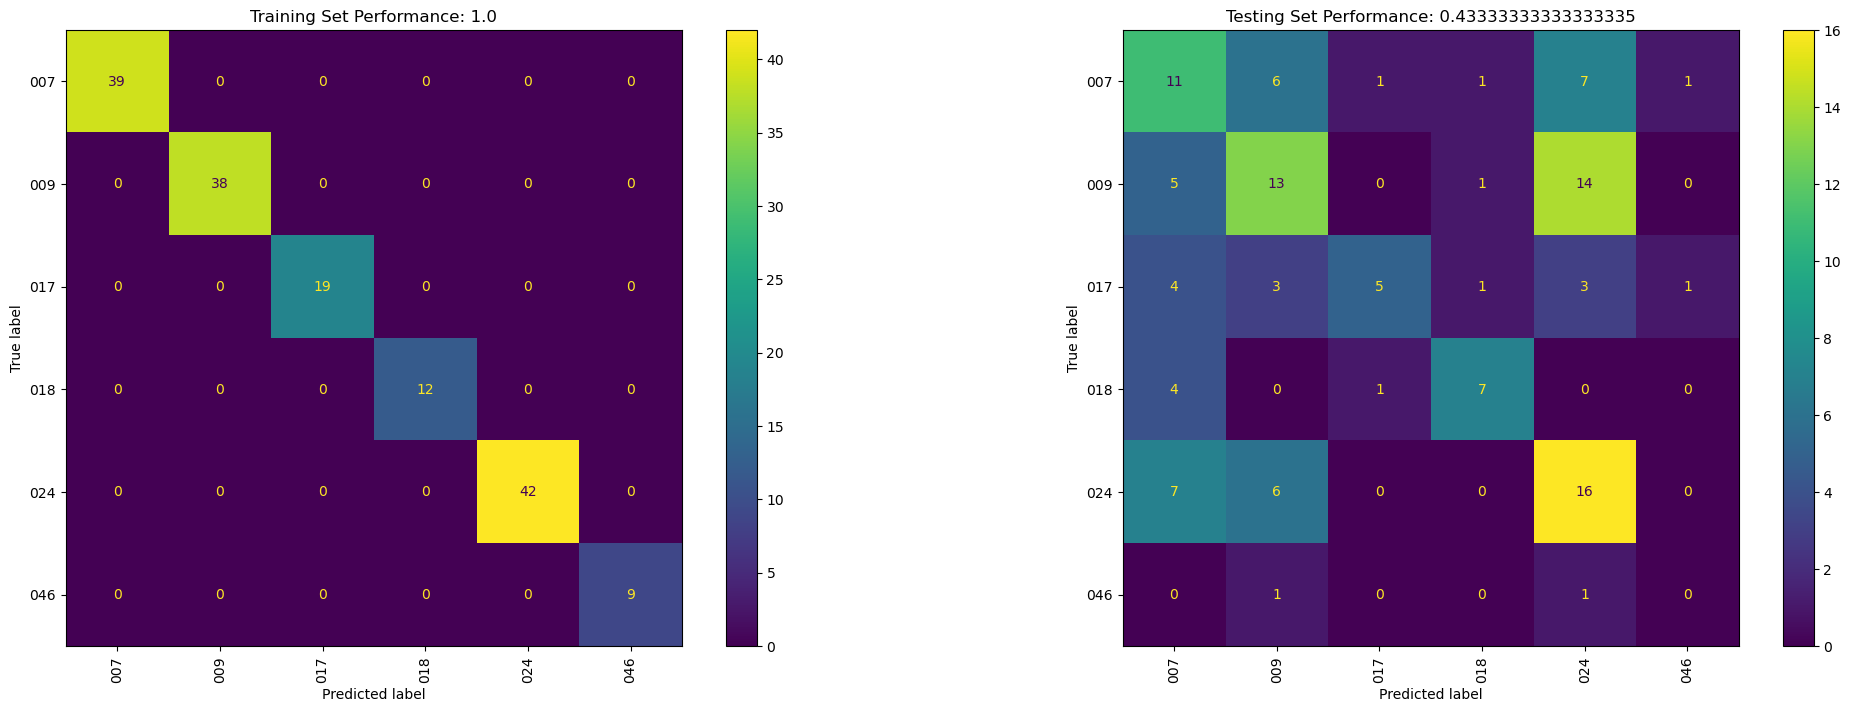

In [280]:
#plot_cm(rf_model, test_X_flat, test_Y)

eval_model(rf_model, train_X_flat, train_Y, test_X_flat, test_Y)
print(rf_est, rf_depth, rf_weight)

(159, 53824)
(120, 53824)
(120, 53824)
[[0.24932803 0.12457744 0.18381452 ... 0.10092279 0.         0.03365868]
 [0.2244096  0.19669975 0.18752597 ... 0.13940814 0.27041285 0.24733845]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.17168825 0.02166993 0.05288475 ... 0.05945745 0.06029177 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.05311312 0.01873377 0.         ... 0.00335955 0.0060085  0.24092957]]


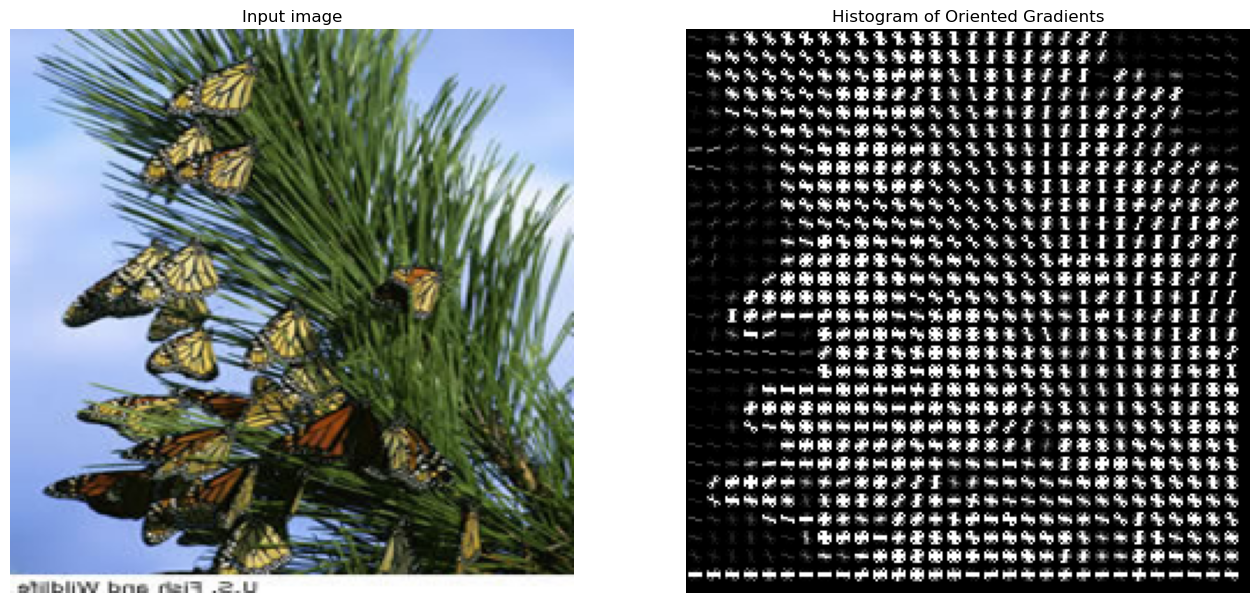

In [293]:
train_X_hog = convert_to_hog(train_X)
test_X_hog = convert_to_hog(test_X)
val_X_hog = convert_to_hog(val_X)

print(train_X_hog.shape)
print(test_X_hog.shape)
print(val_X_hog.shape)
print(train_X_hog)

plot_hogimages(train_X, 9)

In [277]:
hog_model, hog_est, hog_depth, hog_weight = train_randomforest(train_X_hog, train_Y, val_X_hog, val_Y)

# Average Time = 1m 58s

/var/folders/kw/4lv3k6gd2ll5n2vv3vyhqqvc0000gn/T/ipykernel_32494/1103213170.py:67: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm(num_est):


  0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         007       0.41      0.52      0.46        27
         009       0.70      0.70      0.70        33
         017       0.57      0.47      0.52        17
         018       0.83      0.42      0.56        12
         024       0.50      0.55      0.52        29
         046       1.00      0.50      0.67         2

    accuracy                           0.56       120
   macro avg       0.67      0.53      0.57       120
weighted avg       0.59      0.56      0.56       120

800 8 balanced_subsample


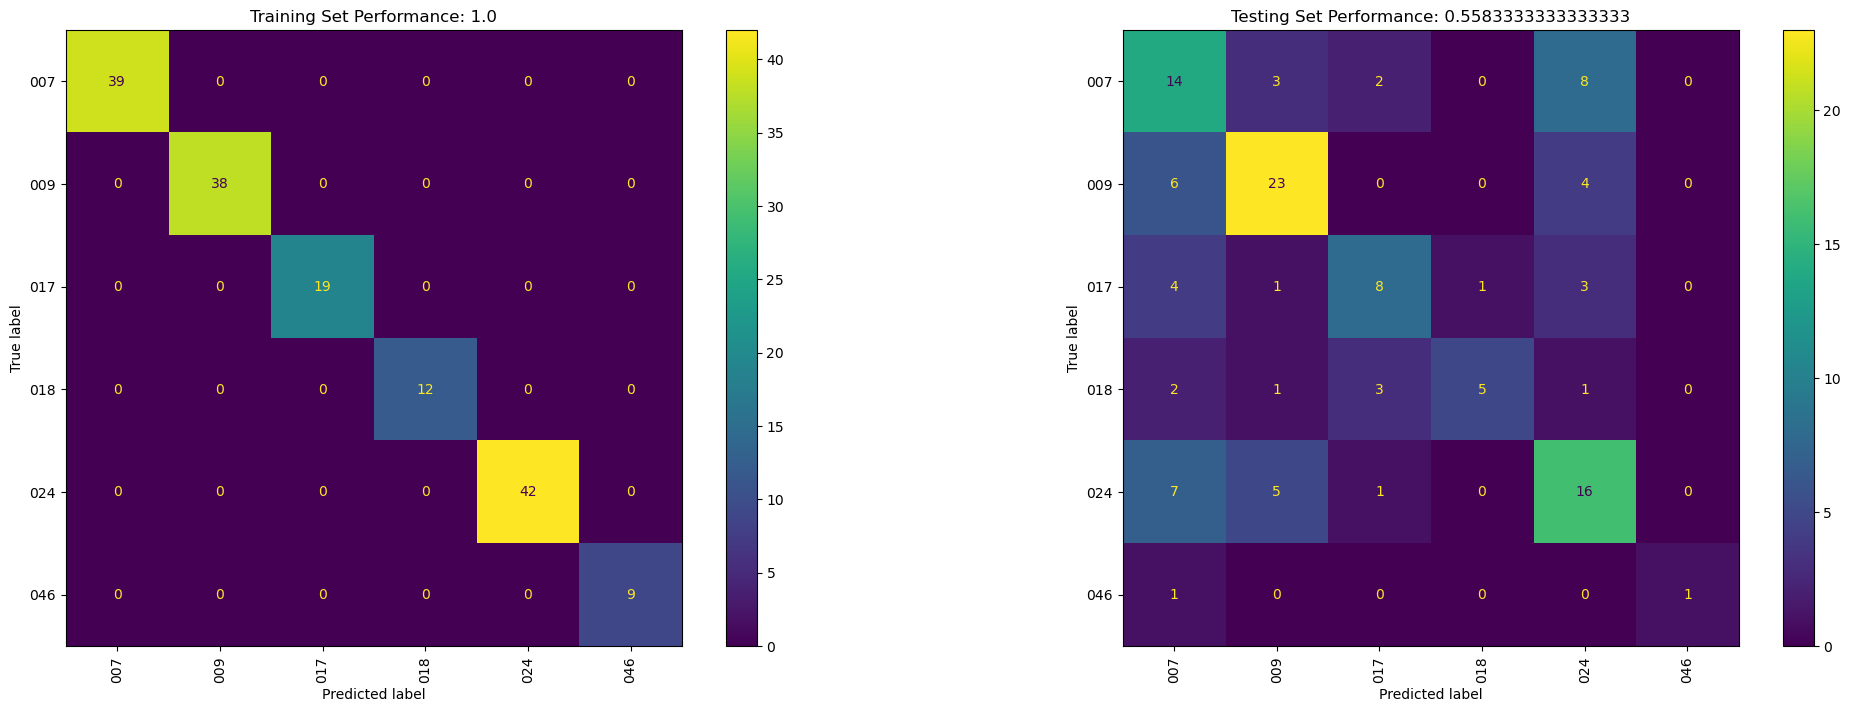

In [278]:
#plot_cm(hog_model, test_X_hog, test_Y)

eval_model(hog_model, train_X_hog, train_Y, test_X_hog, test_Y)
print(hog_est, hog_depth, hog_weight)

007


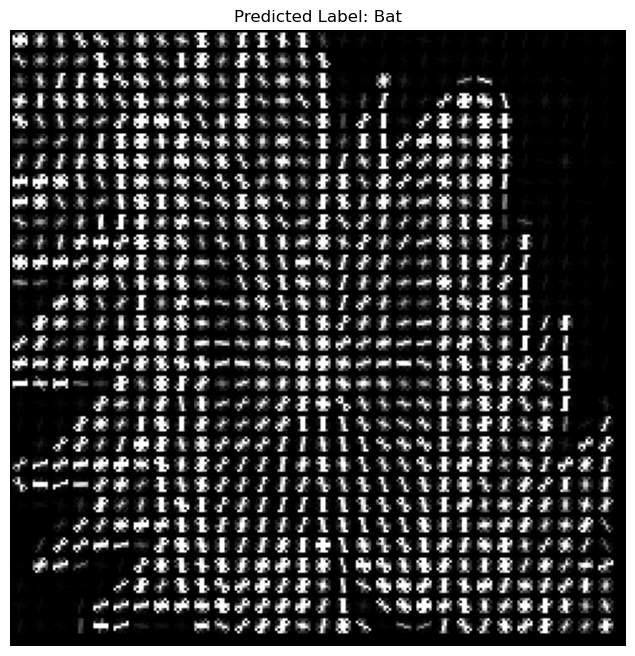

In [352]:
#np.test_X_hog.resize(244, 244)
#hog_resized = np.resize(test_X_hog, (244, 244, 3))

# fd, hog_image = hog(train_X[image_num,:,:,:], orientations=16, pixels_per_cell=(8, 8),
#                     cells_per_block=(2, 2), visualize=True, channel_axis=2)

#     # display image and HOG representation
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
#     ax1.axis('off')
#     ax1.imshow(train_X[image_num,:,:,:], cmap=plt.cm.gray)
#     ax1.set_title('Input image')
#     # Rescale histogram for better display
#     hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
#     ax2.axis('off')
#     ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
#     ax2.set_title('Histogram of Oriented Gradients')
#     plt.show()

image_num_hog = 3

fd, hog_image = hog(train_X[image_num_hog,:,:,:], orientations=16, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=True, channel_axis=2)

fig, ax1 = plt.subplots(1, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax1.axis('off')
ax1.imshow(hog_image_rescaled, cmap=plt.cm.gray)
if pred_images[image_num_hog] == '007':
    display = 'Bat'
if pred_images[image_num_hog] == '009':
    display = 'Bear'
if pred_images[image_num_hog] == '024':
    display = 'Butterfly'
ax1.set_title('Predicted Label: ' + display)
print(pred_images[image_num_hog])